<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

// needed to generate the Table of contents 
// taken from github.com/kmahelona/ipython_notebook_goodies

<IPython.core.display.Javascript object>

# Modeling
Importing modules and data from prevoius step


In [2]:
## Fit Models with Training Data Set
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fast')

import seaborn as sns

In [3]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [4]:
#Load data and scaler model

X_train_scaled = pd.read_csv("../data/X_train_scaled.csv").to_numpy()
y_train = pd.read_csv("../data/y_train.csv").to_numpy().ravel()
X_train_over_scaled = pd.read_csv("../data/X_train_over_scaled.csv").to_numpy()
y_train_over = pd.read_csv("../data/y_train_over.csv").to_numpy().ravel()
X_test_scaled = pd.read_csv("../data/X_test_scaled.csv").to_numpy()
y_test = pd.read_csv("../data/y_test.csv").to_numpy().ravel()
feature_list = pd.read_csv("../data/feature_list.csv")
feature_list = pd.Index(list(feature_list["0"]))

scaler = joblib.load("../data/scaler.pkl")

In [5]:
train_df = pd.DataFrame(X_train_scaled, columns = feature_list)
train_df.head()

,cycle_time,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,0.00000,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662
1,0.00277,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014
2,0.00554,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375
3,0.00831,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386
4,0.01108,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502


In [6]:
train_over_df = pd.DataFrame(X_train_over_scaled, columns = feature_list)
train_over_df.head()

,cycle_time,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,0.576177,0.933735,0.596032,0.808913,0.294686,0.666667,0.019923,0.821429,0.249467,0.558824,0.025183,0.874952,0.750000,0.232558,0.255316
1,0.531856,0.647590,0.526924,0.633187,0.439614,0.378788,0.422911,0.517857,0.520256,0.235294,0.463980,0.529434,0.583333,0.465116,0.352665
2,0.792244,0.524096,0.629387,0.910702,0.322061,0.560606,0.126447,0.785714,0.219616,0.661765,0.093044,0.825702,0.583333,0.387597,0.320077
3,0.448753,0.704819,0.373011,0.614619,0.520129,0.363636,0.314502,0.511905,0.494670,0.338235,0.322531,0.443247,0.583333,0.403101,0.488401
4,0.554017,0.665663,0.751908,0.854828,0.285024,0.303030,0.521583,0.678571,0.336887,0.411765,0.568170,0.642940,0.750000,0.240310,0.159348


In [7]:
test_df = pd.DataFrame(X_test_scaled, columns = feature_list)
test_df.head()

,cycle_time,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,0.00000,0.545181,0.310661,0.269413,0.652174,0.212121,0.127614,0.208333,0.646055,0.220588,0.132160,0.308965,0.333333,0.558140,0.661834
1,0.00277,0.150602,0.379551,0.222316,0.805153,0.166667,0.146684,0.386905,0.739872,0.264706,0.204768,0.213159,0.416667,0.682171,0.686827
2,0.00554,0.376506,0.346632,0.322248,0.685990,0.227273,0.158081,0.386905,0.699360,0.220588,0.155640,0.458638,0.416667,0.728682,0.721348
3,0.00831,0.370482,0.285154,0.408001,0.679549,0.196970,0.105717,0.255952,0.573561,0.250000,0.170090,0.257022,0.250000,0.666667,0.662110
4,0.01108,0.391566,0.352082,0.332039,0.694042,0.166667,0.102396,0.273810,0.737740,0.220588,0.152751,0.300885,0.166667,0.658915,0.716377


## Fit Models with Training Data Set

Let's build some useful functions

In [107]:
def my_cost_function(y_test, y_pred):
    cost_matrix = [[0,1,1],[1,0,1],[20,10,0]]
    conf_matrix = confusion_matrix(y_test, y_pred)
    loss = -np.sum(conf_matrix*cost_matrix)
    return loss

my_score = make_scorer(my_cost_function, greater_is_better=False)

In [108]:
def try_model(model, X_train, y_train, X_test, y_test):
    """ Fits a model on the selected data with the default parameters 
    ex. usage 
        summary = try_model(KNeighborsClassifier(),X_train, y_train)"""
    # statements
    print('Trying Model :'+ str(model))
    start = timer()
    model.fit(X_train, y_train)
    middle = timer()
    test_score = model.score(X_test, y_test)
    end = timer()
    train_score = model.score(X_train, y_train) 
    
    
    #my_test_score = cross_val_score(model, X_test, y_test, cv=2, scoring=my_score)
    #print("|  Mean Cost: %0.2f (+/- %0.2f)" % (my_test_score.mean(), my_test_score.std() * 2))
    
    # calculate confusion matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cost = my_cost_function(y_test, y_pred)
    
    print('|  Train Score: ' + str(round(train_score,3)))
    print('|  Test Score: ' + str(round(test_score,3)))
    
    train_elapsed = round(middle - start,3)
    test_elapsed = round(end - middle,3)

    summary = {'model_name': str(model),
               'training time [s]': train_elapsed,
               'test time [s]': test_elapsed,
               'test accuracy': test_score,
               'cost':cost,
               'train accuracy': train_score,
              'confusion matrix': cm,
              'trained_model':model}
    #print(summary)
    
    return summary

In [109]:
def plot_multiclass_confusion_matrix(y_test, y_pred, categories):
    """Plots the confusion matrix given the data and the lables."""
    
    cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    
    group_counts = ["{0:0.0f}\n".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    stats_text = "\n\nAccuracy={:0.2f}%".format(100*np.trace(cm) / float(np.sum(cm)))
    
    box_labels = [f"{v2}{v3}".strip() for v2, v3 in zip(group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cm.shape[0],cm.shape[1])

    fig = plt.figure(figsize=(6,6))
    sns.set(font_scale=1.4)
    ax = sns.heatmap(cm, annot=box_labels, fmt='', cmap='Blues', xticklabels=categories, yticklabels=categories)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_title(stats_text)
    
    return fig, ax
 

In [110]:
models_summary = pd.DataFrame()
models_summary_over = pd.DataFrame()



### Dummy Classifier


In [111]:
strategies = ['most_frequent', 'stratified', 'prior', 'uniform']

for s in tqdm(strategies) :
    res = try_model(DummyClassifier(strategy=s), X_train_scaled, y_train, X_test_scaled, y_test)
    models_summary = models_summary.append(res, ignore_index=True)
    res_over = try_model(DummyClassifier(strategy=s), X_train_over_scaled, y_train_over, X_test_scaled, y_test)
    models_summary_over = models_summary_over.append(res_over, ignore_index=True)


Trying Model :DummyClassifier(strategy='most_frequent')
|  Train Score: 0.515
|  Test Score: 0.761
Trying Model :DummyClassifier(strategy='most_frequent')
|  Train Score: 0.333
|  Test Score: 0.065
Trying Model :DummyClassifier(strategy='stratified')
|  Train Score: 0.388
|  Test Score: 0.454
Trying Model :DummyClassifier(strategy='stratified')
|  Train Score: 0.33
|  Test Score: 0.339
Trying Model :DummyClassifier(strategy='prior')
|  Train Score: 0.515
|  Test Score: 0.761
Trying Model :DummyClassifier(strategy='prior')
|  Train Score: 0.333
|  Test Score: 0.065
Trying Model :DummyClassifier(strategy='uniform')
|  Train Score: 0.336
|  Test Score: 0.334
Trying Model :DummyClassifier(strategy='uniform')
|  Train Score: 0.338
|  Test Score: 0.34



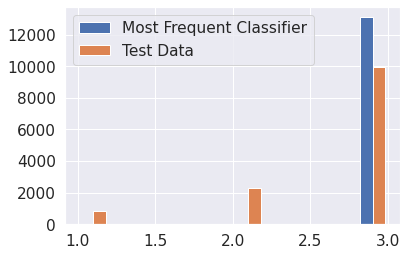

In [112]:
clf_dummy = DummyClassifier(strategy='most_frequent').fit(X_train_scaled, y_train)
y_dummy = clf_dummy.predict(X_test_scaled)
plt.hist([y_dummy, y_test])
plt.legend(['Most Frequent Classifier', 'Test Data'])

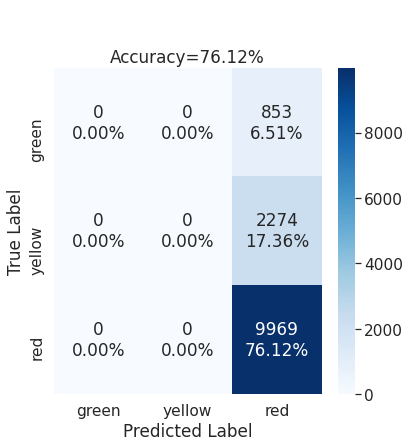

In [113]:
_ = plot_multiclass_confusion_matrix(y_test, clf_dummy.predict(X_test_scaled),['green','yellow','red'])


In [114]:
models_summary

,confusion matrix,cost,model_name,test accuracy,test time [s],train accuracy,trained_model,training time [s]
0,"[[0, 0, 853], [0, 0, 2274], [0, 0, 9969]]",-3127.0,DummyClassifier(strategy='most_frequent'),0.761225,0.001,0.515293,DummyClassifier(strategy='most_frequent'),0.002
1,"[[205, 195, 453], [571, 534, 1169], [2420, 249...",-75738.0,DummyClassifier(strategy='stratified'),0.454261,0.004,0.387524,DummyClassifier(strategy='stratified'),0.001
2,"[[0, 0, 853], [0, 0, 2274], [0, 0, 9969]]",-3127.0,DummyClassifier(strategy='prior'),0.761225,0.001,0.515293,DummyClassifier(strategy='prior'),0.001
3,"[[262, 293, 298], [800, 725, 749], [3328, 3304...",-101740.0,DummyClassifier(strategy='uniform'),0.333537,0.001,0.336096,DummyClassifier(strategy='uniform'),0.001


In [115]:
models_summary_over

,confusion matrix,cost,model_name,test accuracy,test time [s],train accuracy,trained_model,training time [s]
0,"[[853, 0, 0], [2274, 0, 0], [9969, 0, 0]]",-201654.0,DummyClassifier(strategy='most_frequent'),0.065134,0.001,0.333333,DummyClassifier(strategy='most_frequent'),0.002
1,"[[282, 293, 278], [768, 746, 760], [3223, 3373...",-100289.0,DummyClassifier(strategy='stratified'),0.339493,0.004,0.330229,DummyClassifier(strategy='stratified'),0.001
2,"[[853, 0, 0], [2274, 0, 0], [9969, 0, 0]]",-201654.0,DummyClassifier(strategy='prior'),0.065134,0.001,0.333333,DummyClassifier(strategy='prior'),0.001
3,"[[292, 299, 262], [711, 739, 824], [3259, 3337...",-100646.0,DummyClassifier(strategy='uniform'),0.340486,0.001,0.337911,DummyClassifier(strategy='uniform'),0.001


--> The Dummy Classifier: Most Frequent has 0.761 Accuracy!

In [116]:
models_summary_over['trained_model'][0].predict(X_test_scaled)

array([1, 1, 1, ..., 1, 1, 1])

### Test stock models (Default Parameters)
- KNeighborsClassifier
- SVC - Linear and RBF
- DecisionTreeClassifier
- RandomForestClassifier
- AdaBoostClassifier
- GradientBoostingClassifier




In [117]:
models_to_try = [KNeighborsClassifier(),
                 KNeighborsClassifier(3),
                 DecisionTreeClassifier(),
                 DecisionTreeClassifier(criterion='gini',max_depth=3),
                 RandomForestClassifier(),
                 RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
                 SVC(),
                 SVC(kernel="linear", C=0.025),
                 AdaBoostClassifier(),
                 GradientBoostingClassifier()
                ]
short_names = ['most_frequent', 'stratified', 'prior', 'uniform'] + ['KNN()',
                 'KNN(3)',
                 'Tree()',
                 'Tree(gini,d=3)',
                 'RandomForest()',
                 'RF(d=5, n=10, f=1)',
                 'SVC()',
                 'SVC("linear", C=0.025)',
                 'Ada()',
                 'Gradient()'
                ]

In [118]:
for m in tqdm(models_to_try) :
    res = try_model(m, X_train_scaled, y_train, X_test_scaled, y_test)
    models_summary = models_summary.append(res, ignore_index=True)
    res_over = try_model(m, X_train_over_scaled, y_train_over, X_test_scaled, y_test)
    models_summary_over = models_summary_over.append(res_over, ignore_index=True)
    


Trying Model :KNeighborsClassifier()
|  Train Score: 0.848
|  Test Score: 0.802
Trying Model :KNeighborsClassifier()
|  Train Score: 0.896
|  Test Score: 0.746
Trying Model :KNeighborsClassifier(n_neighbors=3)
|  Train Score: 0.875
|  Test Score: 0.79
Trying Model :KNeighborsClassifier(n_neighbors=3)
|  Train Score: 0.937
|  Test Score: 0.746
Trying Model :DecisionTreeClassifier()
|  Train Score: 1.0
|  Test Score: 0.764
Trying Model :DecisionTreeClassifier()
|  Train Score: 1.0
|  Test Score: 0.771
Trying Model :DecisionTreeClassifier(max_depth=3)
|  Train Score: 0.758
|  Test Score: 0.776
Trying Model :DecisionTreeClassifier(max_depth=3)
|  Train Score: 0.745
|  Test Score: 0.769
Trying Model :RandomForestClassifier()
|  Train Score: 1.0
|  Test Score: 0.832
Trying Model :RandomForestClassifier()
|  Train Score: 1.0
|  Test Score: 0.83
Trying Model :RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10)
|  Train Score: 0.778
|  Test Score: 0.824
Trying Model :RandomFore

In [119]:
models_summary.sort_values(by=['test accuracy'], ascending=False)

,confusion matrix,cost,model_name,test accuracy,test time [s],train accuracy,trained_model,training time [s]
10,"[[520, 294, 39], [88, 1224, 962], [10, 716, 92...",-8743.0,SVC(),0.838958,5.153,0.810043,SVC(),10.249
13,"[[576, 253, 24], [127, 1311, 836], [19, 886, 9...",-10480.0,GradientBoostingClassifier(),0.836210,0.043,0.831419,([DecisionTreeRegressor(criterion='friedman_ms...,17.907
12,"[[585, 227, 41], [210, 1050, 1014], [85, 598, ...",-9172.0,AdaBoostClassifier(),0.833919,0.142,0.782027,"(DecisionTreeClassifier(max_depth=1, random_st...",1.393
8,"[[548, 276, 29], [112, 1288, 874], [24, 882, 9...",-10591.0,RandomForestClassifier(),0.832239,0.190,1.000000,"(DecisionTreeClassifier(max_features='auto', r...",3.771
11,"[[519, 275, 59], [110, 947, 1217], [27, 589, 9...",-8091.0,"SVC(C=0.025, kernel='linear')",0.826130,2.347,0.781785,"SVC(C=0.025, kernel='linear')",6.609
9,"[[563, 184, 106], [161, 458, 1655], [45, 148, ...",-4486.0,"RandomForestClassifier(max_depth=5, max_featur...",0.824450,0.011,0.778392,"(DecisionTreeClassifier(max_depth=5, max_featu...",0.083
4,"[[568, 239, 46], [235, 1116, 923], [112, 1040,...",-14083.0,KNeighborsClassifier(),0.801848,4.269,0.848093,KNeighborsClassifier(),0.049
5,"[[571, 234, 48], [293, 1040, 941], [191, 1043,...",-15766.0,KNeighborsClassifier(n_neighbors=3),0.790012,4.046,0.874509,KNeighborsClassifier(n_neighbors=3),0.049
7,"[[524, 310, 19], [179, 1410, 685], [50, 1694, ...",-19133.0,DecisionTreeClassifier(max_depth=3),0.775733,0.001,0.758422,DecisionTreeClassifier(max_depth=3),0.057
6,"[[540, 252, 61], [253, 1162, 859], [167, 1505,...",-19815.0,DecisionTreeClassifier(),0.763516,0.002,1.000000,DecisionTreeClassifier(),0.261


In [120]:
models_summary_over.sort_values(by=['test accuracy'], ascending=False)

,confusion matrix,cost,model_name,test accuracy,test time [s],train accuracy,trained_model,training time [s]
8,"[[554, 274, 25], [118, 1394, 762], [23, 1026, ...",-11899.0,RandomForestClassifier(),0.829872,0.199,1.000000,"(DecisionTreeClassifier(max_features='auto', r...",5.311
12,"[[596, 242, 15], [220, 1409, 645], [70, 1271, ...",-15232.0,AdaBoostClassifier(),0.811927,0.124,0.763835,"(DecisionTreeClassifier(max_depth=1, random_st...",1.902
13,"[[580, 268, 5], [140, 1690, 444], [23, 1677, 8...",-18087.0,GradientBoostingClassifier(),0.804750,0.044,0.828771,([DecisionTreeRegressor(criterion='friedman_ms...,26.560
11,"[[530, 307, 16], [119, 1618, 537], [26, 1599, ...",-17489.0,"SVC(C=0.025, kernel='linear')",0.801161,4.246,0.774245,"SVC(C=0.025, kernel='linear')",16.340
9,"[[517, 318, 18], [139, 1323, 812], [30, 1296, ...",-14847.0,"RandomForestClassifier(max_depth=5, max_featur...",0.800473,0.011,0.759320,"(DecisionTreeClassifier(max_depth=5, max_featu...",0.115
10,"[[527, 322, 4], [85, 1804, 385], [9, 1910, 8050]]",-20076.0,SVC(),0.792685,8.587,0.803154,SVC(),25.787
6,"[[528, 250, 75], [256, 1044, 974], [146, 1303,...",-17505.0,DecisionTreeClassifier(),0.770617,0.002,1.000000,DecisionTreeClassifier(),0.342
7,"[[526, 320, 7], [176, 1505, 593], [56, 1871, 8...",-20926.0,DecisionTreeClassifier(max_depth=3),0.769166,0.001,0.744615,DecisionTreeClassifier(max_depth=3),0.078
4,"[[562, 263, 28], [306, 1369, 599], [192, 1933,...",-24366.0,KNeighborsClassifier(),0.746411,5.834,0.896059,KNeighborsClassifier(),0.087
5,"[[544, 276, 33], [278, 1278, 718], [166, 1850,...",-23125.0,KNeighborsClassifier(n_neighbors=3),0.746411,5.780,0.936538,KNeighborsClassifier(n_neighbors=3),0.103


In [121]:
models_summary.sort_values(by=['cost'], ascending=False)

,confusion matrix,cost,model_name,test accuracy,test time [s],train accuracy,trained_model,training time [s]
0,"[[0, 0, 853], [0, 0, 2274], [0, 0, 9969]]",-3127.0,DummyClassifier(strategy='most_frequent'),0.761225,0.001,0.515293,DummyClassifier(strategy='most_frequent'),0.002
2,"[[0, 0, 853], [0, 0, 2274], [0, 0, 9969]]",-3127.0,DummyClassifier(strategy='prior'),0.761225,0.001,0.515293,DummyClassifier(strategy='prior'),0.001
9,"[[563, 184, 106], [161, 458, 1655], [45, 148, ...",-4486.0,"RandomForestClassifier(max_depth=5, max_featur...",0.824450,0.011,0.778392,"(DecisionTreeClassifier(max_depth=5, max_featu...",0.083
11,"[[519, 275, 59], [110, 947, 1217], [27, 589, 9...",-8091.0,"SVC(C=0.025, kernel='linear')",0.826130,2.347,0.781785,"SVC(C=0.025, kernel='linear')",6.609
10,"[[520, 294, 39], [88, 1224, 962], [10, 716, 92...",-8743.0,SVC(),0.838958,5.153,0.810043,SVC(),10.249
12,"[[585, 227, 41], [210, 1050, 1014], [85, 598, ...",-9172.0,AdaBoostClassifier(),0.833919,0.142,0.782027,"(DecisionTreeClassifier(max_depth=1, random_st...",1.393
13,"[[576, 253, 24], [127, 1311, 836], [19, 886, 9...",-10480.0,GradientBoostingClassifier(),0.836210,0.043,0.831419,([DecisionTreeRegressor(criterion='friedman_ms...,17.907
8,"[[548, 276, 29], [112, 1288, 874], [24, 882, 9...",-10591.0,RandomForestClassifier(),0.832239,0.190,1.000000,"(DecisionTreeClassifier(max_features='auto', r...",3.771
4,"[[568, 239, 46], [235, 1116, 923], [112, 1040,...",-14083.0,KNeighborsClassifier(),0.801848,4.269,0.848093,KNeighborsClassifier(),0.049
5,"[[571, 234, 48], [293, 1040, 941], [191, 1043,...",-15766.0,KNeighborsClassifier(n_neighbors=3),0.790012,4.046,0.874509,KNeighborsClassifier(n_neighbors=3),0.049


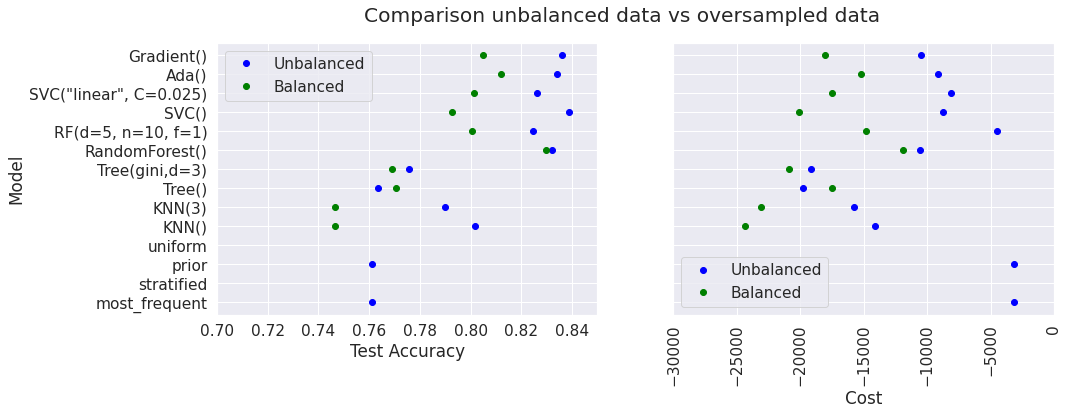

In [131]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
fig.suptitle('Comparison unbalanced data vs oversampled data')

_ = ax[0].plot(models_summary['test accuracy'],models_summary['model_name'],'o',linestyle='None',color='blue')
_ = ax[0].plot(models_summary_over['test accuracy'],models_summary_over['model_name'],'o',linestyle='None',color='green')
_ = ax[0].legend(['Unbalanced', 'Balanced'])
labels = short_names
_ = ax[0].set_yticklabels(labels, rotation=0)
_ = ax[0].set_xlim([0.7,0.85])
#_ = ax[0].set_title('Test Accuracy')
_ = ax[0].set_xlabel('Test Accuracy')
_ = ax[0].set_ylabel('Model')

_ = ax[1].plot(models_summary['cost'],models_summary['model_name'],'o',linestyle='None',color='blue')
_ = ax[1].plot(models_summary_over['cost'],models_summary_over['model_name'],'o',linestyle='None',color='green')
_ = ax[1].legend(['Unbalanced', 'Balanced'])
labels = short_names
_ = ax[1].set_yticklabels(labels, rotation=0)
_ = plt.xticks(rotation=90)
_ = ax[1].set_xlim([-30000, 0])
#ax[1].set_title('Cost')
_ = ax[1].set_xlabel('Cost')
#ax[1].set_ylabel('Cost')

plt.savefig("../figures/Naive_model_comparison.png") 

In [ ]:
#custom scoring test

# params = {'C' : np.arange(1,100,50)}

# grid_accuracy = GridSearchCV(SVC(),params,scoring=my_score,cv=5).fit(X_train_scaled, y_train)
# grid_custom = GridSearchCV(SVC(),params,scoring='accuracy',cv=5).fit(X_train_scaled, y_train)

In [ ]:
# y_pred = grid.predict(X_test_scaled)
# cm = confusion_matrix(y_test, y_pred)

In [ ]:
# cm

In [ ]:
# plot__multiclass_confusion_matrix(y_test, y_pred,['green','yellow','red'])

In [28]:
#plot confusion matrix for top accuracy and top cost

## Review Model Outcomes — Iterate over additional models as needed.
-> pick top 2  and run hyperparameters tuning

SVC('rbf')
RF()


### GridSearchCV

- SVC - linear RBF (best accuracy)

- Random Forest (lowest cost)




In [ ]:
# model_grid = {'KNeighborsClassifier':{'n_neighbors':np.arange(1,101,10)},
#              'DecisionTreeClassifier':{'criterion':['gini', 'entropy'],
#                                        'max_depth':np.arange(2,10,1)},
#              'RandomForestClassifier':{'n_estimators':np.arange(50,201,50),
#                                        'criterion':['gini', 'entropy'],
#                                        'max_depth':np.arange(1,11,2)},
#               'SVC_linear':{'C' : np.arange(1,100,10),
#                      'kernel': ['linear'],
#                      'gamma' : ['scale','auto']},
#               'SVC_RBF':{'C' : np.arange(1,100,10),
#                      'kernel': ['rbf'],
#                      'gamma' : ['scale','auto']},
#               'AdaBoostClassifier':{'n_estimators': [10,20,30,40,50],
#                                     'learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1]},
#               'GradientBoostingClassifier':{'n_estimators': [10,20,30,40,50],
#                                             'learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1],
#                                             'max_features': [2,3,4,5,6,7,8,9],
#                                             'max_depth' : [2,3,4,5,6]},
#               'XGBClassifier':{'learning_rate': np.arange(0.01, 1.0,0.5),
#                                'n_estimators': np.arange(100, 1000,500),
#                                'max_depth': np.arange(3,10,3),
#                                'gamma': np.arange(0, 5,2)}
#              }              

In [123]:
model_grid = {'SVC_RBF':{'C' : np.arange(1,100,10),
                         'kernel': ['linear','rbf'],
                         'gamma' : ['scale','auto']},
              'RandomForestClassifier':{'n_estimators':np.arange(50,201,50),
                                        'criterion':['gini', 'entropy'],
                                        'max_depth':np.arange(1,11,2)}
             }             
models = {'SVC_RBF': SVC(),
              'RandomForestClassifier':RandomForestClassifier()
             }             

In [ ]:
for m in tqdm(model_grid.keys()):
    print(m)

In [ ]:
# WAY TOO LONG
# # XGBoost
# from xgboost import XGBClassifier
# param_grid = {'learning_rate': np.arange(0.01, 1.0,0.5),
#                                'n_estimators': np.arange(100, 1000,500),
#                                'max_depth': np.arange(3,10,3),
#                                'gamma': np.arange(0, 5,2)}

# xgb = XGBClassifier()
# xgb_cv= GridSearchCV(xgb,param_grid,cv=3)
# start = timer()
# xgb_cv.fit(X_train_scaled,y_train)
# end = timer()
# print(str(round(end - start,3)) + ' seconds elapsed.')

# #print("Best Score:" + str(xgb_cv.best_score_))
# #print("Best Parameters: " + str(xgb_cv.best_params_))

In [ ]:
# def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
#     # Get Test Scores Mean and std for each grid search
#     scores_mean = cv_results['mean_test_score']
#     scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

#     scores_sd = cv_results['std_test_score']
#     scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

#     # Plot Grid search scores
#     _, ax = plt.subplots(1,1)

#     # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
#     for idx, val in enumerate(grid_param_2):
#         ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

#     ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
#     ax.set_xlabel(name_param_1, fontsize=16)
#     ax.set_ylabel('CV Average Score', fontsize=16)
#     ax.legend(loc="best", fontsize=15)
#     ax.grid('on')

# # Calling Method 
# plot_grid_search(tree_cv.cv_results_, param_grid['max_depth'], param_grid['criterion'], 'max_depth', 'criterion' )

In [ ]:
# print("Best Score:" + str(xgb_cv.best_score_))
# print("Best Parameters: " + str(xgb_cv.best_params_))

## Identify the Final Model
choose final model and make predictions